In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

from chromatix.elements import FFLens
from chromatix.field import ScalarField

In [2]:
key = jax.random.PRNGKey(0)

In [44]:
objective = FFLens(
    f=10e3,  # focal length in microns
    n=1.5,  # refractive index
    NA=0.1,  # numerical aperture
)

tube = FFLens(
    f=200e3,  # focal length in microns
    n=1.5,  # refractive index
    NA=0.03,  # numerical aperture
)

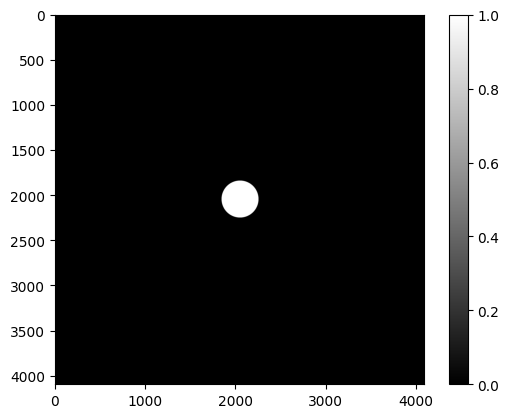

In [51]:
speckle_radius = 10
size = 4096

input = jnp.ones((size, size), dtype=jnp.complex64)
mask = jnp.zeros((size, size), dtype=jnp.complex64)
y, x = jnp.ogrid[-size // 2 : size // 2, -size // 2 : size // 2]
mask = x**2 + y**2 <= (size / speckle_radius / 2) ** 2
input = jnp.where(mask, input, 0.0)
plt.imshow(jnp.abs(input), cmap="gray")
plt.colorbar()
plt.show()

In [52]:
input_field = ScalarField.create(
    dx=0.266,  # spacing in microns
    spectrum=0.532,  # wavelength in microns
    spectral_density=1.0,
    u=input[None, :, :, None, None],
    shape=(size, size),
)

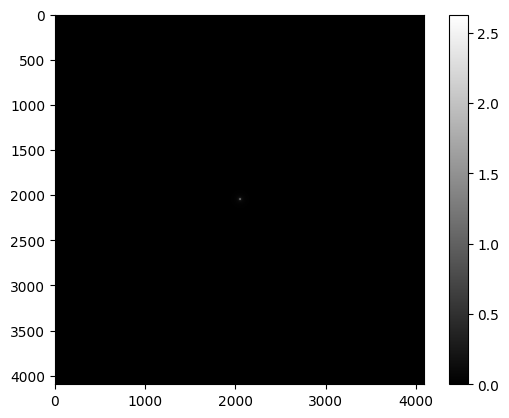

In [53]:
params_obj = objective.init(key, input_field)
output_obj = objective.apply(
    params_obj,  # Empty params if no learnable parameters
    input_field,
)
plt.imshow(jnp.abs(output_obj.u[0, ..., 0]), cmap="gray")
plt.colorbar()
plt.show()

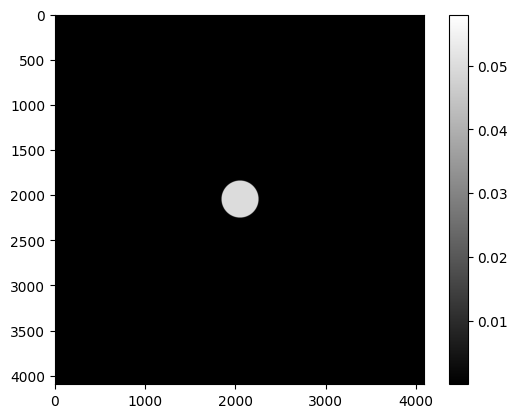

In [54]:
params_tube = tube.init(key, output_obj)
output_tube = tube.apply(
    params_tube,  # Empty params if no learnable parameters
    output_obj,
)
plt.imshow(jnp.abs(output_tube.u[0, ..., 0]), cmap="gray")
plt.colorbar()
plt.show()

In [55]:
output_obj.dx, output_tube.dx

(Array([[[[[[3.2552085]]]]],
 
 
 
 
        [[[[[3.2552085]]]]]], dtype=float32, weak_type=True),
 Array([[[[[[5.3199997]]]]],
 
 
 
 
        [[[[[5.3199997]]]]]], dtype=float32, weak_type=True))

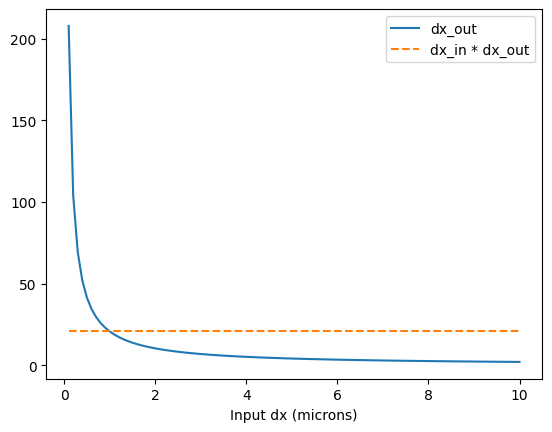

In [ ]:
# dx_out w.r.t. dx_in
input_dxes = jnp.linspace(0.1, 10, 100)
output_dxes = jnp.zeros_like(input_dxes)
for i, dx in enumerate(input_dxes):
    input_field = ScalarField.create(
        dx=dx,  # spacing in microns
        spectrum=0.532,  # wavelength in microns
        spectral_density=1.0,
        u=input,
        shape=(128, 128),
    )
    output_field = objective.apply(
        params_obj,  # Empty params if no learnable parameters
        input_field,
    )
    output_dxes = output_dxes.at[i].set(output_field.dx[0, 0, 0, 0, 0, 0])

plt.plot(input_dxes, output_dxes, label="dx_out", linestyle="-")
plt.plot(input_dxes, input_dxes * output_dxes, label="dx_in * dx_out", linestyle="--")
plt.xlabel("Input dx (microns)")
plt.legend()
plt.show()

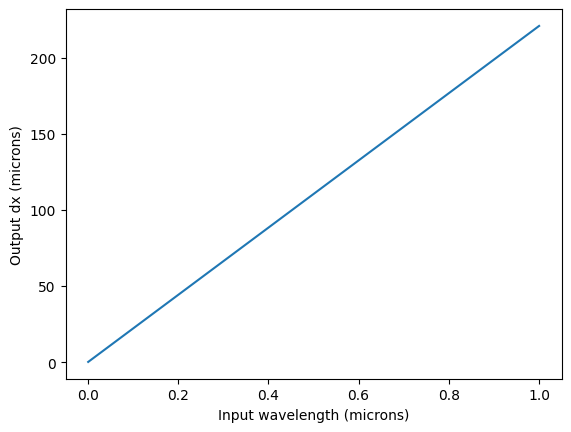

In [ ]:
# dx_out w.r.t. wavelength
wavelengths = jnp.linspace(0.001, 1, 100)
output_dxes = jnp.zeros_like(wavelengths)
for i, wavelength in enumerate(wavelengths):
    input_field = ScalarField.create(
        dx=0.266,  # spacing in microns
        spectrum=wavelength,  # wavelength in microns
        spectral_density=1.0,
        u=input,
        shape=(128, 128),
    )
    output_field = objective.apply(
        params_obj,  # Empty params if no learnable parameters
        input_field,
    )
    output_dxes = output_dxes.at[i].set(output_field.dx[0, 0, 0, 0, 0, 0])

plt.plot(wavelengths, output_dxes, label="dx_out", linestyle="-")
plt.xlabel("Input wavelength (microns)")
plt.ylabel("Output dx (microns)")
plt.show()

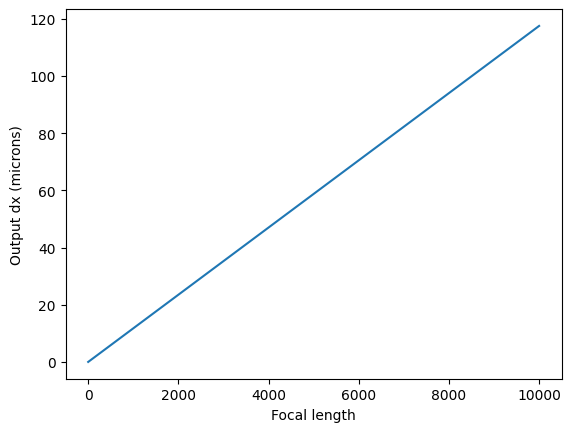

In [ ]:
# dx_out w.r.t. focal length
focal_lengths = jnp.linspace(1, 10000, 100)
output_dxes = jnp.zeros_like(focal_lengths)
for i, focal_length in enumerate(focal_lengths):
    input_field = ScalarField.create(
        dx=0.266,  # spacing in microns
        spectrum=0.532,  # wavelength in microns
        spectral_density=1.0,
        u=input,
        shape=(128, 128),
    )
    objective = FFLens(
        f=focal_length,  # focal length in microns
        n=1.33,  # refractive index
        NA=0.8,  # numerical aperture
    )
    params_obj = objective.init(key, input_field)
    output_field = objective.apply(
        params_obj,  # Empty params if no learnable parameters
        input_field,
    )
    output_dxes = output_dxes.at[i].set(output_field.dx[0, 0, 0, 0, 0, 0])

plt.plot(focal_lengths, output_dxes, label="dx_out", linestyle="-")
plt.xlabel("Focal length")
plt.ylabel("Output dx (microns)")
plt.show()

In [ ]:
0.532 * 100 / 128 / 1.33  # dx_in * dx_out = wavelength * focal_length / refractive_index / shape_per_axis

0.3125

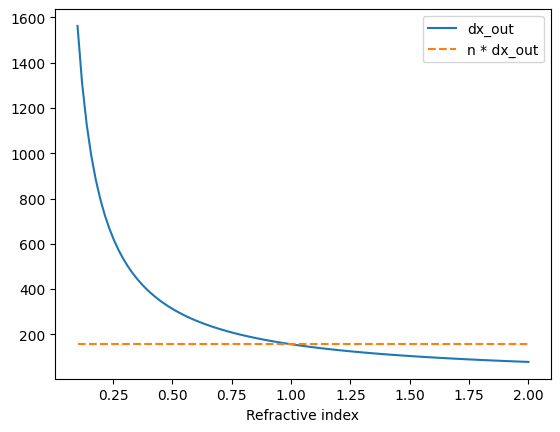

In [ ]:
# dx_out w.r.t. refractive index
refractive_indices = jnp.linspace(0.1, 2, 100)
output_dxes = jnp.zeros_like(refractive_indices)
for i, refractive_index in enumerate(refractive_indices):
    input_field = ScalarField.create(
        dx=0.266,  # spacing in microns
        spectrum=0.532,  # wavelength in microns
        spectral_density=1.0,
        u=input,
        shape=(128, 128),
    )
    objective = FFLens(
        f=10000,  # focal length in microns
        n=refractive_index,  # refractive index
        NA=0.8,  # numerical aperture
    )
    params_obj = objective.init(key, input_field)
    output_field = objective.apply(
        params_obj,  # Empty params if no learnable parameters
        input_field,
    )
    output_dxes = output_dxes.at[i].set(output_field.dx[0, 0, 0, 0, 0, 0])

plt.plot(refractive_indices, output_dxes, label="dx_out", linestyle="-")
plt.plot(
    refractive_indices,
    refractive_indices * output_dxes,
    label="n * dx_out",
    linestyle="--",
)
plt.xlabel("Refractive index")
plt.legend()
plt.show()

100it [01:48,  1.08s/it]


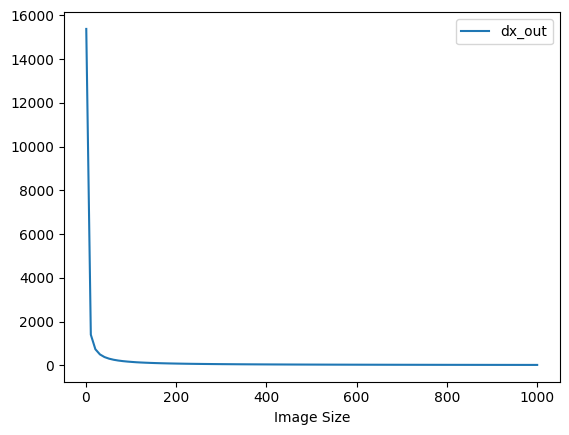

In [ ]:
# dx_out w.r.t. shape
sizes = jnp.linspace(1, 1000, 100)
output_dxes = jnp.zeros_like(sizes)
for i, size in tqdm(enumerate(sizes)):
    input_field = ScalarField.create(
        dx=0.266,  # spacing in microns
        spectrum=0.532,  # wavelength in microns
        spectral_density=1.0,
        u=jnp.ones((1, int(size), int(size), 1, 1), dtype=jnp.complex64),
        shape=(size, size),
    )
    objective = FFLens(
        f=10000,  # focal length in microns
        n=1.3,  # refractive index
        NA=0.8,  # numerical aperture
    )
    params_obj = objective.init(key, input_field)
    output_field = objective.apply(
        params_obj,  # Empty params if no learnable parameters
        input_field,
    )
    output_dxes = output_dxes.at[i].set(output_field.dx[0, 0, 0, 0, 0, 0])

plt.plot(sizes, output_dxes, label="dx_out", linestyle="-")
plt.plot(sizes, sizes * output_dxes, label="size * dx_out", linestyle="--")
plt.xlabel("Image Size")
plt.legend()
plt.show()

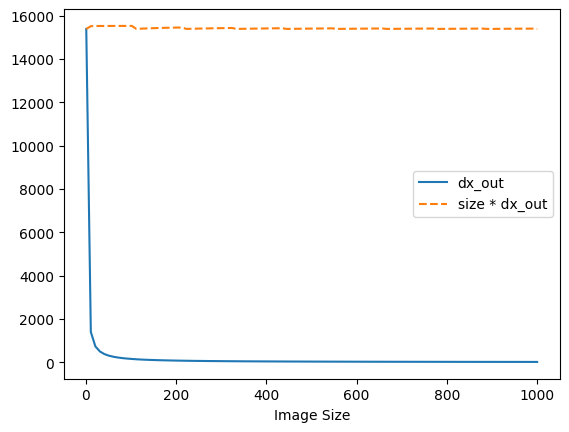

In [5]:
plt.plot(sizes, output_dxes, label="dx_out", linestyle="-")
plt.plot(sizes, sizes * output_dxes, label="size * dx_out", linestyle="--")
plt.xlabel("Image Size")
plt.legend()
plt.show()

In [37]:
output_field.shape

(1, 128, 128, 1, 1)

In [27]:
0.532 * 10000 / 0.266 / 1.3 / 128

120.1923076923077